In [1]:
from ibmdbpy import IdaDataBase, IdaDataFrame
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve


In [2]:
credentials_1 = {
    'username': 'username',
    'password': """password""",
    'sg_service_url': 'url',
    'database': 'BLUDB',
    'host': 'host',
    'port': 'port',
    'auto_discovery': 'true',
}
df = IdaDataFrame(idadb_c568b279819b490d915961aba3c756c5, 'BXJ33585.LENDINGCLUB').as_dataframe()
df.columns = df.columns.str.lower()

In [9]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,grade_predicted
0,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,...,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,C
1,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,...,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,G
2,68446771,7200.0,7200.0,7200.0,36 months,15.77,252.32,D,D1,< 1 year,...,0.0,1.0,255047.0,275831.0,6700.0,246447.0,N,Cash,N,B
3,68376217,23100.0,23100.0,23100.0,60 months,20.50,618.46,E,E4,2 years,...,0.0,0.0,102524.0,55048.0,21700.0,80824.0,N,Cash,N,G
4,68446746,12000.0,12000.0,12000.0,36 months,5.32,361.38,A,A1,4 years,...,0.0,0.0,183062.0,11146.0,8500.0,29053.0,N,Cash,N,A


In [4]:
columns = ['id','application_type','loan_amnt','purpose','annual_inc','fico_range_low','term','dti','revol_bal','revol_util',
           'inq_last_6mths','delinq_2yrs','pub_rec','total_bal_il','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim', 
           'grade']

In [5]:
df2 = df[columns].copy()

In [6]:
pd.set_option('display.max_rows', 400)

## Resample

In [7]:
X, y = df2.drop('grade', axis=1), df2['grade']

In [11]:
X_resampled, y_resampled = X, y

## Data Transformation

In [12]:
def transform_purpose(value):
    if value in ['debt_consolidation', 'credit_card','medical', 'house', 'car', 'small_business', 'other']:
        return value
    else:
        return 'personal'

def transform_application_type(value):
    if str(value).strip() == 'individual':
        return 1
    else:
        return 2
    
def transform_term(value):
    value = value.split()[0]
    return int(value)


X_resampled['purpose'] = X_resampled['purpose'].apply(transform_purpose)

In [13]:
def strip(value):
    return str(value).strip()

In [14]:
for i in X_resampled.select_dtypes('object').columns:
    X_resampled[i] = X_resampled[i].apply(strip) 

## Split Training Testing Set

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, random_state=0)

In [17]:
X_train_reindex = X_train.reset_index().drop('index', axis=1)
X_test_reindex = X_test.reset_index().drop('index', axis=1)

## Modeling

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
ohePurpose = OneHotEncoder()
X_trainOHE = ohePurpose.fit_transform(X_train[['purpose']])
X_testOHE = ohePurpose.transform(X_test[['purpose']])

X_trainOHE = pd.DataFrame(X_trainOHE.toarray(), columns=ohePurpose.categories_)
X_testOHE = pd.DataFrame(X_testOHE.toarray(), columns=ohePurpose.categories_)

In [20]:
X_trainOHE.columns = ['_'.join(col) for col in X_trainOHE.columns]
X_testOHE.columns = ['_'.join(col) for col in X_testOHE.columns]

In [21]:
X_trainFinal = pd.concat([X_train_reindex, X_trainOHE], axis=1).drop('purpose', axis=1)
X_testFinal = pd.concat([X_test_reindex, X_testOHE], axis=1).drop('purpose', axis=1)

In [22]:
X_trainFinal['application_type'] = X_trainFinal['application_type'].apply(transform_application_type)
X_testFinal['application_type'] = X_testFinal['application_type'].apply(transform_application_type)
X_trainFinal['term'] = X_trainFinal['term'].apply(transform_term)
X_testFinal['term'] = X_testFinal['term'].apply(transform_term)

## 1. What could be the rules that differentiate between grade A and B?

In [23]:
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(negations=True, returnOrd=True)

In [24]:
train = X_train.copy()
train['grade'] = le.inverse_transform(y_train)

In [25]:
test = X_test.copy()
test['grade'] = le.inverse_transform(y_test)

In [26]:
trainAB = train[train['grade'].isin(['A','B'])]
testAB = test[test['grade'].isin(['A','B'])]

In [27]:
tempLE = LabelEncoder()

In [28]:
X_trainAB = trainAB.drop('grade', axis=1)
y_trainAB = tempLE.fit_transform(trainAB['grade'])

In [29]:
X_testAB = testAB.drop('grade', axis=1)
y_testAB = tempLE.transform(testAB['grade'])

In [30]:
X_trainAB_Save = X_trainAB.copy()
X_testAB_Save = X_testAB.copy()

In [31]:
X_trainAB, X_trainStd = fb.fit_transform(X_trainAB)
X_testAB, X_testStd = fb.transform(X_testAB)

In [32]:
from aix360.algorithms.rbm import BooleanRuleCG
br = BooleanRuleCG(lambda0 = 0.001, lambda1 = 0.001, CNF=True)

In [33]:
tempLE.classes_

array(['A', 'B'], dtype=object)

### 1.1 Using Boolean Rule Column Generation

In [34]:
br.fit(X_trainAB, y_trainAB)

from sklearn.metrics import accuracy_score
print('Training accuracy:', accuracy_score(y_trainAB, br.predict(X_trainAB)))
print('Test accuracy:', accuracy_score(y_testAB, br.predict(X_testAB)))
print('Predict Y=0 [A] if ANY of the following rules are satisfied, otherwise Y=1 [B]:')
print(br.explain()['rules'])

Learning CNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.3221
Iteration: 2, Objective: 0.2811
Iteration: 3, Objective: 0.2811
Iteration: 4, Objective: 0.2811
Iteration: 5, Objective: 0.2786
Iteration: 6, Objective: 0.2786
Iteration: 7, Objective: 0.2786
Training accuracy: 0.7243675099866844
Test accuracy: 0.7152847152847153
Predict Y=0 [A] if ANY of the following rules are satisfied, otherwise Y=1 [B]:
['fico_range_low > 700.00 AND term not ']


Rules in here meaning that:

```If your fico score more than 700 and Term is 36 months, then you're grade A, else B```

### 1.2 Using Logistic Rule Regression

In [35]:
from aix360.algorithms.rbm import LogisticRuleRegression
lrr = LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)

# Train, print, and evaluate model
lrr.fit(X_trainAB, y_trainAB, X_trainStd)
print('Training accuracy:', accuracy_score(y_trainAB, lrr.predict(X_trainAB, X_trainStd)))
print('Test accuracy:', accuracy_score(y_testAB, lrr.predict(X_testAB, X_testStd)))
print('Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))')
print('where z is a linear combination of the following rules/numerical features:')
lrr.explain()

/home/jupyter-ariff/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jupyter-ariff/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jupyter-ariff/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jupyter-ariff/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training accuracy: 0.747503328894807
Test accuracy: 0.7357642357642358
Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))
where z is a linear combination of the following rules/numerical features:


,rule/numerical feature,coefficient
0,(intercept),0.467627
1,term,1.80864
2,term not,-1.41895
3,fico_range_low,-1.37287
4,application_type not AND purpose != house AND...,-1.05526
5,purpose != house AND purpose != medical AND pu...,-0.809793
6,id <= 105042485.80,-0.49988
7,tot_hi_cred_lim <= 68908.30,0.496476
8,fico_range_low <= 710.00,0.492631
9,id <= 126356403.40,0.477911


#### As your FICO score higher, your chances to be in grade A also increases

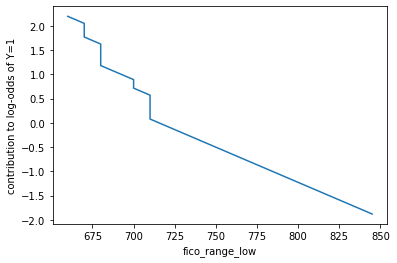

In [36]:
lrr.visualize(X, fb, ['fico_range_low']);

#### As you take long term , your chances to be in grade A also decreases

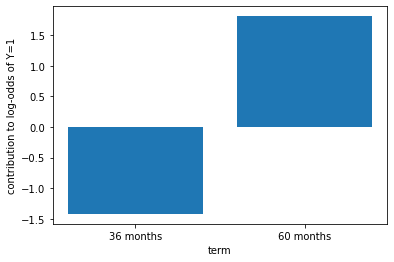

In [58]:
lrr.visualize(X, fb, ['term']);

#### As your revolving line utilization rate is higher, your chances to be in grade A also decreases

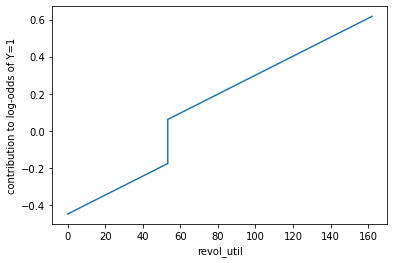

In [38]:
lrr.visualize(X, fb, ['revol_util']);

#### As your number of inquiries in past 6 months higher, your chances to be in grade A also decreases

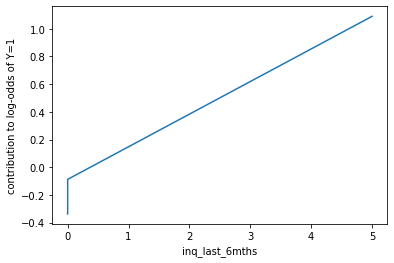

In [39]:
lrr.visualize(X, fb, ['inq_last_6mths']);

# 2. What is the minimal improvement need to be done to get grade A from grade G using Constrastive Explanations

In [40]:
leAG = LabelEncoder()

In [41]:
X_trainFinalAG = X_trainFinal.drop('id', axis=1).copy()
X_trainFinalAG['grade'] = le.inverse_transform(y_train)
X_trainFinalAG = X_trainFinalAG[X_trainFinalAG['grade'].isin(['A','G'])]
y_trainFinalAG = leAG.fit_transform(X_trainFinalAG['grade'])
X_trainFinalAG = X_trainFinalAG.drop('grade', axis=1)

In [42]:
X_testFinalAG = X_testFinal.drop('id', axis=1).copy()
X_testFinalAG['grade'] = le.inverse_transform(y_test)
X_testFinalAG = X_testFinalAG[X_testFinalAG['grade'].isin(['A','G'])]
y_testFinalAG = leAG.fit_transform(X_testFinalAG['grade'])
X_testFinalAG = X_testFinalAG.drop('grade', axis=1)

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-0.5,0.5))
X_trainFinalScaled = scaler.fit_transform(X_trainFinalAG)
X_testFinalScaled = scaler.fit_transform(X_testFinalAG)

In [44]:
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier

Using TensorFlow backend.


In [45]:
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
import tensorflow as tf

In [46]:
def nn_small(num_input):
    model = Sequential()
    model.add(Dense(12, input_dim=num_input, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    return model

In [47]:
leAG.classes_

array(['A', 'G'], dtype=object)

In [48]:
np.random.seed(42)
tf.set_random_seed(42)

class_names = list(leAG.classes_)

nn = nn_small(X_trainFinalScaled.shape[1])
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [49]:
nn.fit(X_trainFinalScaled, y_trainFinalAG, batch_size=128, epochs=100, verbose=1, shuffle=False)
nn.save_weights('loan_grade_weights.h5')


Epoch 1/100
6008/6008 [==============================] - 0s 32us/step - loss: 0.6833 - accuracy: 0.7117
Epoch 2/100
6008/6008 [==============================] - 0s 11us/step - loss: 0.6502 - accuracy: 0.7921
Epoch 3/100
6008/6008 [==============================] - 0s 9us/step - loss: 0.5879 - accuracy: 0.8341
Epoch 4/100
6008/6008 [==============================] - 0s 11us/step - loss: 0.5143 - accuracy: 0.8587
Epoch 5/100
6008/6008 [==============================] - 0s 9us/step - loss: 0.4445 - accuracy: 0.8790
Epoch 6/100
6008/6008 [==============================] - 0s 9us/step - loss: 0.3858 - accuracy: 0.8893
Epoch 7/100
6008/6008 [==============================] - 0s 10us/step - loss: 0.3396 - accuracy: 0.8993
Epoch 8/100
6008/6008 [==============================] - 0s 9us/step - loss: 0.3021 - accuracy: 0.9050
Epoch 9/100
6008/6008 [==============================] - 0s 9us/step - loss: 0.2738 - accuracy: 0.9083
Epoch 10/100
6008/6008 [==============================] - 0s 8us/ste

In [50]:
# evaluate model accuracy        
score = nn.evaluate(X_trainFinalScaled, y_trainFinalAG, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(X_testFinalScaled, y_testFinalAG, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train accuracy: 0.9342543482780457
Test accuracy: 0.9330669045448303


In [51]:
y_trainPredicted = nn.predict_classes(X_trainFinalScaled)

y_testPredicted = nn.predict_classes(X_testFinalScaled)

In [52]:
dfAG = pd.DataFrame(scaler.inverse_transform(X_testFinalScaled), columns=X_testFinal.drop('id', axis=1).columns)

In [53]:
dfAG['grade'] = leAG.inverse_transform(y_testFinalAG)
dfAG['predicted_grade'] = leAG.inverse_transform(y_testPredicted)

/home/jupyter-ariff/.local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
X_testFinalSave = X_testFinal.loc[X_testFinalAG.index, :].copy()

### 2.1 Get one customer predicted as Grade G to check what he/she need to do to get to grade A

In [55]:
clientG = dfAG[dfAG['predicted_grade'] == 'G']

In [56]:
clientG.head()

,application_type,loan_amnt,annual_inc,fico_range_low,term,dti,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,...,car,credit_card,debt_consolidation,house,medical,other,personal,small_business,grade,predicted_grade
0,2.0,20400.0,58000.0,695.0,60.0,19.02,2263.0,83.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,G,G
2,2.0,10000.0,84000.0,670.0,60.0,32.19,10703.0,56.6,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G,G
6,2.0,17250.0,52000.0,705.0,60.0,27.03,17003.0,65.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G,G
7,2.0,35000.0,80000.0,745.0,60.0,10.37,6204.0,19.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,G,G
8,2.0,15725.0,52460.0,665.0,36.0,15.10,6739.0,57.1,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G,G


In [64]:
idx = 0

In [65]:
clientG0 = X_testFinalScaled[idx,:].reshape((1,) + X_testFinalScaled[idx,:].shape)

In [66]:
clientG0

array([[-0.5       , -0.0025641 , -0.45444338, -0.31081081,  0.5       ,
        -0.46424812, -0.49360666,  0.23187773, -0.5       , -0.5       ,
        -0.5       , -0.4809264 , -0.49388846, -0.48697366, -0.48866067,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
         0.5       , -0.5       , -0.5       ]])

In [67]:
mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 500 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 100 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.02 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 0.03 # Controls sparsity of the solution (L1 loss)
arg_gamma = 1 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder

# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(clientG0, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)






iter:0 const:[100.]
Loss_Overall:1000101.8750, Loss_Attack:1000101.8750
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9988, max_nontarget_lab_score:-10000.0000

iter:250 const:[100.]
Loss_Overall:1000101.8750, Loss_Attack:1000101.8750
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9988, max_nontarget_lab_score:-10000.0000

iter:0 const:[1000.]
Loss_Overall:10001014.0000, Loss_Attack:10001014.0000
Loss_L2Dist:0.0119, Loss_L1Dist:0.1581, AE_loss:0.0
target_lab_score:0.9942, max_nontarget_lab_score:-10000.0000

iter:250 const:[1000.]
Loss_Overall:10000023.0000, Loss_Attack:10000022.0000
Loss_L2Dist:1.1084, Loss_L1Dist:1.4824, AE_loss:0.0
target_lab_score:0.0026, max_nontarget_lab_score:-10000.0000

iter:0 const:[10000.]
Loss_Overall:100000208.0000, Loss_Attack:100000208.0000
Loss_L2Dist:1.3870, Loss_L1Dist:2.4384, AE_loss:0.0
target_lab_score:0.0011, max_nontarget_lab_score:-10000.0000

iter:250 const:[10000.]
Loss_Overall:100000192.00

In [68]:
leAG.inverse_transform(nn.predict_classes(adv_pn))

array(['A'], dtype=object)

In [69]:
dfclientA = pd.DataFrame(scaler.inverse_transform(adv_pn), columns=X_testFinalAG.columns).T
dfclientA.rename(columns={0:'A'},inplace=True)

In [70]:
dfclientSelected = pd.DataFrame(scaler.inverse_transform(clientG0), columns=X_testFinalAG.columns).T
dfclientSelected.rename(columns={0:'G'},inplace=True)

In [71]:
diffASelected = dfclientA['A'] - dfclientSelected['G']

In [72]:
diffASelected = pd.DataFrame(diffASelected, columns=['Different'])

In [73]:
pd.concat([dfclientSelected, dfclientA, diffASelected], axis=1)

,G,A,Different
application_type,2.00,2.50,0.50
loan_amnt,20400.00,20500.00,100.00
annual_inc,58000.00,624600.00,566600.00
fico_range_low,695.00,752.50,57.50
term,60.00,48.00,-12.00
dti,19.02,266.00,246.98
revol_bal,2263.00,176981.00,174718.00
revol_util,83.80,57.25,-26.55
inq_last_6mths,0.00,2.50,2.50
delinq_2yrs,0.00,6.00,6.00


The improvement needed are to be in grade G from A:

- less the loan term, at max 48 months
- lower you revolving utilization rate
- increase your annual income

### 2.2 Get one customer predicted as Grade C to check what he/she need to do to get to grade B

In [74]:
leBC = LabelEncoder()

In [75]:
X_trainFinalBC = X_trainFinal.copy()
X_trainFinalBC['grade'] = le.inverse_transform(y_train)
X_trainFinalBC = X_trainFinalBC[X_trainFinalBC['grade'].isin(['B','C'])]
y_trainFinalBC = leBC.fit_transform(X_trainFinalBC['grade'])
X_trainFinalBC = X_trainFinalBC.drop('grade', axis=1)

In [76]:
X_testFinalBC = X_testFinal.copy()
X_testFinalBC['grade'] = le.inverse_transform(y_test)
X_testFinalBC = X_testFinalBC[X_testFinalBC['grade'].isin(['B','C'])]
y_testFinalBC = leBC.fit_transform(X_testFinalBC['grade'])
X_testFinalBC = X_testFinalBC.drop('grade', axis=1)

In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-0.5,0.5))
X_trainFinalScaled = scaler.fit_transform(X_trainFinalBC)
X_testFinalScaled = scaler.fit_transform(X_testFinalBC)

In [78]:
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier

In [79]:
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
import tensorflow as tf

In [80]:
def nn_small(num_input):
    model = Sequential()
    model.add(Dense(12, input_dim=num_input, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    return model

In [81]:
leBC.classes_

array(['B', 'C'], dtype=object)

In [82]:
np.random.seed(42)
tf.set_random_seed(42)

class_names = list(leBC.classes_)

nn = nn_small(X_trainFinalScaled.shape[1])
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [83]:
nn.fit(X_trainFinalScaled, y_trainFinalBC, batch_size=128, epochs=100, verbose=1, shuffle=False)
nn.save_weights('loan_grade_weights.h5')


Epoch 1/100
6008/6008 [==============================] - 0s 30us/step - loss: 0.6921 - accuracy: 0.5183
Epoch 2/100
6008/6008 [==============================] - 0s 8us/step - loss: 0.6887 - accuracy: 0.5652
Epoch 3/100
6008/6008 [==============================] - 0s 8us/step - loss: 0.6836 - accuracy: 0.5774
Epoch 4/100
6008/6008 [==============================] - 0s 8us/step - loss: 0.6772 - accuracy: 0.5904
Epoch 5/100
6008/6008 [==============================] - 0s 10us/step - loss: 0.6709 - accuracy: 0.5942
Epoch 6/100
6008/6008 [==============================] - 0s 9us/step - loss: 0.6654 - accuracy: 0.5982
Epoch 7/100
6008/6008 [==============================] - 0s 10us/step - loss: 0.6607 - accuracy: 0.6034
Epoch 8/100
6008/6008 [==============================] - 0s 8us/step - loss: 0.6567 - accuracy: 0.6092
Epoch 9/100
6008/6008 [==============================] - 0s 10us/step - loss: 0.6534 - accuracy: 0.6128
Epoch 10/100
6008/6008 [==============================] - 0s 8us/ste

In [84]:
# evaluate model accuracy        
score = nn.evaluate(X_trainFinalScaled, y_trainFinalBC, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(X_testFinalScaled, y_testFinalBC, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train accuracy: 0.6446405053138733
Test accuracy: 0.6258741021156311


In [85]:
y_trainPredicted = nn.predict_classes(X_trainFinalScaled)

y_testPredicted = nn.predict_classes(X_testFinalScaled)

In [86]:
dfBC = pd.DataFrame(scaler.inverse_transform(X_testFinalScaled), columns=X_testFinal.columns)

In [87]:
dfBC['grade'] = leBC.inverse_transform(y_testFinalBC)
dfBC['predicted_grade'] = leBC.inverse_transform(y_testPredicted)

/home/jupyter-ariff/.local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
clientC = dfBC[dfBC['predicted_grade'] == 'C']

In [90]:
clientC.head()

,id,application_type,loan_amnt,annual_inc,fico_range_low,term,dti,revol_bal,revol_util,inq_last_6mths,...,car,credit_card,debt_consolidation,house,medical,other,personal,small_business,grade,predicted_grade
3,108106895.0,2.0,14000.0,152000.0,695.0,60.0,16.30,23069.0,52.8,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,C,C
4,139156966.0,2.0,10000.0,45000.0,705.0,60.0,26.45,7202.0,43.4,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,B,C
5,75230741.0,2.0,12000.0,45000.0,660.0,36.0,10.58,5772.0,25.9,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,C,C
7,126788231.0,2.0,15000.0,97000.0,670.0,60.0,6.00,5643.0,20.4,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,C,C
8,130806291.0,2.0,40000.0,20455.0,705.0,60.0,112.50,31769.0,74.8,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,B,C


In [91]:
idx = 9

In [92]:
clientC.iloc[idx,:]

id                    1.3749e+08
application_type               2
loan_amnt                  20000
annual_inc                 54000
fico_range_low               665
term                          36
dti                         7.62
revol_bal                   8579
revol_util                  11.3
inq_last_6mths                 3
delinq_2yrs                    0
pub_rec                        1
total_bal_il                2687
total_rev_hi_lim           76200
avg_cur_bal                  433
tot_hi_cred_lim            82054
car                            0
credit_card                    0
debt_consolidation             1
house                          0
medical                        0
other                          0
personal                       0
small_business                 0
grade                          B
predicted_grade                C
Name: 18, dtype: object

In [93]:
clientC0 = X_testFinalScaled[idx,:].reshape((1,) + X_testFinalScaled[idx,:].shape)

In [94]:
mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 500 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 1 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.02 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 0.03 # Controls sparsity of the solution (L1 loss)
arg_gamma = 1 # Controls how much to adhere to a (optionally trained) auto-encoder
my_BE_model = None # Pointer to an auto-encoder

# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(clientC0, arg_mode, my_BE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)

iter:0 const:[1.]
Loss_Overall:10000.8799, Loss_Attack:10000.8799
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8608, max_nontarget_lab_score:-10000.0000

iter:250 const:[1.]
Loss_Overall:10000.8799, Loss_Attack:10000.8799
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8608, max_nontarget_lab_score:-10000.0000

iter:0 const:[10.]
Loss_Overall:100008.6797, Loss_Attack:100008.6797
Loss_L2Dist:0.0005, Loss_L1Dist:0.0228, AE_loss:0.0
target_lab_score:0.8483, max_nontarget_lab_score:-10000.0000

iter:250 const:[10.]
Loss_Overall:100003.6250, Loss_Attack:100003.1875
Loss_L2Dist:0.4232, Loss_L1Dist:0.6505, AE_loss:0.0
target_lab_score:0.2989, max_nontarget_lab_score:-10000.0000

iter:0 const:[100.]
Loss_Overall:1000025.1250, Loss_Attack:1000024.6875
Loss_L2Dist:0.3615, Loss_L1Dist:1.2148, AE_loss:0.0
target_lab_score:0.2278, max_nontarget_lab_score:-10000.0000

iter:250 const:[100.]
Loss_Overall:1000011.1250, Loss_Attack:1000009.5625
Loss_L2Dis

In [95]:
leBC.inverse_transform(nn.predict_classes(adv_pn))

array(['B'], dtype=object)

In [96]:
dfclientB = pd.DataFrame(scaler.inverse_transform(adv_pn), columns=X_testFinal.columns).T
dfclientB.rename(columns={0:'B'},inplace=True)

In [97]:
dfclientC0 = pd.DataFrame(scaler.inverse_transform(clientC0), columns=X_testFinal.columns).T
dfclientC0.rename(columns={0:'C'},inplace=True)

In [98]:
diffCB = dfclientB['B'] - dfclientC0['C']

In [99]:
diffCB = pd.DataFrame(diffCB, columns=['Improvement Needed'])

The improvement needed are to be in grade B from C:

- less the loan term, at max 48 months
- lower you revolving utilization rate
- increase your annual income

In [100]:
pd.concat([dfclientC0, dfclientB, diffCB], axis=1)

,C,B,Improvement Needed
id,75061241.00,1.035910e+08,2.852976e+07
application_type,2.00,2.500000e+00,5.000000e-01
loan_amnt,1000.00,2.050000e+04,1.950000e+04
annual_inc,75000.00,7.510000e+05,6.760000e+05
fico_range_low,675.00,7.450000e+02,7.000000e+01
term,36.00,4.800000e+01,1.200000e+01
dti,8.91,3.491150e+02,3.402050e+02
revol_bal,10765.00,3.108715e+05,3.001065e+05
revol_util,94.00,5.200000e+01,-4.200000e+01
inq_last_6mths,4.00,2.500000e+00,-1.500000e+00


## Conclusion

With Boolean Rule and Logistic Rule Regression models, we able to grasp general knowledge on how we can distinguish between good grade and bad grade creditors. And then we proceed with identifying the improvement needed for future creditor to have higher chances of getting their loan approved by giving them general information such as Income, Term of the loan and their utilization of credit card.